# Part 1: Filtering and processing data
The first step of the analysis is to filter the dataframe 'movie.metadata', and to reshape it so that it the relevant features are easily accessible.
#### **1) Importing the data**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json 
import ast
from datetime import datetime


In [55]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
dataframe = pd.read_csv('Data/movie.metadata.tsv', sep='\t', names = ['Wikipedia movieID', 'Freebase movieID', 'Movie name', 'Movie release date', 'Movie box office revenue','Movie runtime', 'Movie languages', 'Movie countries', 'Movie genres' ])

display(dataframe)

,Wikipedia movieID,Freebase movieID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"
...,...,...,...,...,...,...,...,...,...
81736,35228177,/m/0j7hxnt,Mermaids: The Body Found,2011-03-19,NaN,120.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/07s9rl0"": ""Drama""}"
81737,34980460,/m/0g4pl34,Knuckle,2011-01-21,NaN,96.0,"{""/m/02h40lc"": ""English Language""}","{""/m/03rt9"": ""Ireland"", ""/m/07ssc"": ""United Ki...","{""/m/03bxz7"": ""Biographical film"", ""/m/07s9rl0..."
81738,9971909,/m/02pygw1,Another Nice Mess,1972-09-22,NaN,66.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06nbt"": ""Satire"", ""/m/01z4y"": ""Comedy""}"
81739,913762,/m/03pcrp,The Super Dimension Fortress Macross II: Lover...,1992-05-21,NaN,150.0,"{""/m/03_9r"": ""Japanese Language""}","{""/m/03_3d"": ""Japan""}","{""/m/06n90"": ""Science Fiction"", ""/m/0gw5n2f"": ..."


#### **2) Processing the release date column**

In order to perform a study on month of release, we need to check what is the proportion of movies which don't have the month of release. If this proportion is not too high, we can continue our analysis. We then need to process the release date column so that the month and year of release are easily accessible.


Note: At each transformation of the original dataframe, deep copies are performed in order to keep track of its evolution.

**2.1) Create the "Movie release year" column:**

In [6]:
from helpers import select_years

In [7]:
# Deep copy
# df_with_year := add a release year column
df_with_years = dataframe.copy(deep = True)

df_with_years = select_years(df_with_years)

/Users/julespirot/ADA2023/dat4kproject/helpers.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Movie release year'] = df['Movie release date'].str[0:4]
/Users/julespirot/ADA2023/dat4kproject/helpers.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Movie release year'] = pd.to_numeric(df['Movie release year'], errors='raise')


**2.2) Percentage missing month per year:** 

Now that the year of release is accessible, the percentage of missing month per year can be computed, so that we can understand better its evolution.

In [8]:
from helpers import plot_percentage_missing_month_per_year

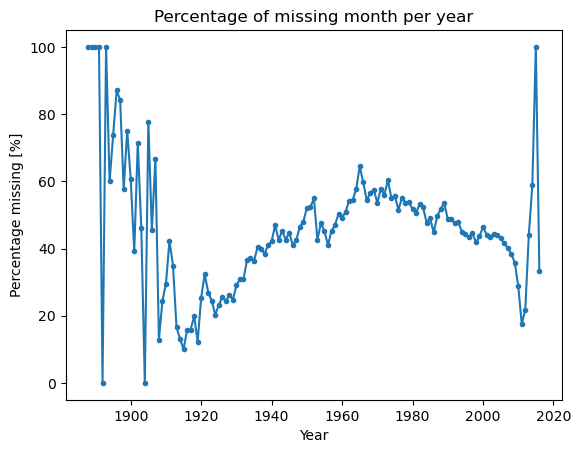

In [9]:
plot_percentage_missing_month_per_year(df_with_years)

In the initial 20 years, the annual percentage of missing months is important and exhibits significant variation. Beginning in the 1920s, it steadily rises from 10% to 60% in the 1960s, followed by a decline to 40% in the 2000s.

**2.3) Proportion of data with a release month:**

In [10]:
from helpers import dataframe_with_months

In [11]:
# Deep copy
# df_with_months := rows which all have release month 
df_with_months = df_with_years.copy(deep=True)
df_with_months = dataframe_with_months(df_with_months)

**2.4) Comparison between the original data and the data with the release month available:** yearly evolution of the number of movies

In [12]:
from helpers import nmbr_movie_years

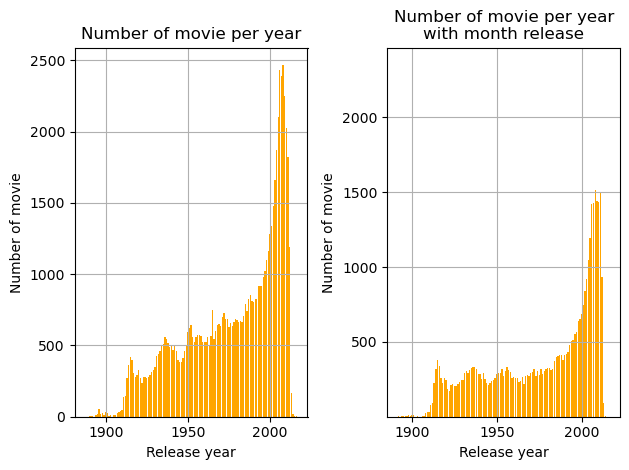

In [13]:
nmbr_movie_years(df_with_years,df_with_months)

In the first plot, the number of movie releases shows a continuous increase from the 1920s to the 1980s, while in the second plot, it remains constant. Starting from the 1980s, both plots exhibit a notable surge in the number of released movies. The period before the 1920s does not show a significantly high number of movie releases. These observations align with the trends depicted in the 'Percentage of missing month per year' plot above.

**2.5) Selecting only the years with enough movies**:

We observe that many years have a relatively low number of movie releases. Given our focus on a yearly analysis, we will exclude years with less than 200 movie releases.

In [14]:
from helpers import select_main_years

In [15]:
# Takes out all the years where the number of movies is under 200
df_main_years = df_with_months.copy(deep=True)
df_main_years = select_main_years(df_main_years,df_with_months)

In [16]:
# Compute the ratio of usable data
ratio = len(df_main_years)*100/len(dataframe)
print(f"The number of movie kept is : {len(df_main_years)}\nWhich corresponds to a ratio of : {ratio:.2f}%")

The number of movie kept is : 41855
Which corresponds to a ratio of : 51.20%


The data which has a release month represent 51.20% of the entire dataframe, and 41 855 movies, which is an acceptable number for our study. We can then go further in the analysis.

**2.6) Splitting the release date column:** the release month is extracted in the cell 'Movie release month' as well as the season.

**Note:** to denote the season, a number between 1 and 4 is assigned following: 
- 1 : Winter
- 2 : Spring
- 3 : Summer
- 4 : Autumn

In [17]:
from helpers import clean_date_and_season

In [18]:
# Deep copy
# df_clean_date := the release date column is seperated into 2 columns for the month, and year of release
df_clean_date = df_main_years.copy(deep=True)
df_clean_date = clean_date_and_season(df_clean_date)


#### **3) Processing the genre column**

Now that the date column is cleaned, the genre column needs also to be processed. The final goal is to assign to each movie 2 main genres which are relevant for our analysis. 


**Note**: The computational time to perform this filtering is very large because of the iteration over all rows of the dataframe. Indeed, the json format of each cells forces us to iterate over each rows.


**3.1) Gathering all genres and their occurrences:**

In order to assign a main genre to each movie, we first need to find all the genres and their occurrences, to understand better how the genre data is organised. To do so, the frame 'nb_genres' is created using the function 'counting_genres', by iterating over 'df_clean_date', and contains each genre name with their respective occurrence.


In [19]:
from helpers_part1 import counting_genres 

In [20]:
nb_genres = counting_genres(df_clean_date)

In [21]:
nb_genres.head(20)

,genre name,nb of movies
0,Drama,18700
1,Comedy,9893
2,Romance Film,6123
3,Black-and-white,5438
4,Thriller,5272
5,Action,5026
6,Crime Fiction,4212
7,Short Film,4114
8,Indie,4054
9,World cinema,3297


Let's plot the number of movies per genre, for all the different genres we found (the genres are denoted by their index, 0 being the most used genre).

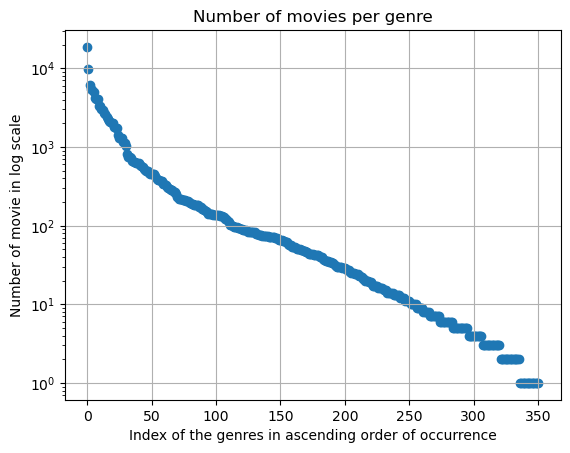

In [22]:
plt.scatter(nb_genres.index,nb_genres['nb of movies'])
plt.yscale("log")
plt.title('Number of movies per genre')
plt.xlabel('Index of the genres in ascending order of occurrence')
plt.ylabel('Number of movie in log scale')
plt.grid()


The 'nb_genres' frame shows that there are 351 different genres, and their occurrence decays as a power low. Indeed, as seen in the above plot, from the 100th genre, there are only 100 or less movies associated to it. This means that taking into account only the first genres will still describe most of the data.

**3.2) Creating main genres clusters**

In the 'nb_genres' frame, one can see that some genres could be grouped together in order to form a bigger group of data. For example, the genre 'Comedy' defines 9893 movies, and the genre 'Comedy film' defines 2423 movies, whereas they could be grouped together. 
Moreover, 8 main genres are chosen to describe the data: 
- Drama
- Comedy
- Romance
- Thriller
- Action
- Family film
- Horror
- Informative

These genres are chosen because they define a high proportion of data, and also because they are the ones which will be relevant further in our study, when the genre of a movie will be presented with respect to the month of release.

The function 'main_genres_cluster' creates the respective genre clusters, and gathers them in a 'main_genres' frame.

In [23]:
from helpers_part1 import main_genres_cluster

The dictionary 'genres_lexical_field' gathers, for each main genre, a lexical field, which allow to find the associated sub-genres. It is then used as input of the function 'main_genres_cluster'.

In [24]:

genres_lexical_field = {'Drama': ['Drama'], 'Comedy': ['Comedy','Slapstick','Parody'],'Romance':['Romance','Romantic'], 
                        'Thriller':['Thriller','Crime'],'Action':['Action','Adventure','War','Western'],'Family film':['Family','Animation'],
                        'Horror':['Horror'],'Informative':['Documentary','Biography','Biopic','History']}

In [25]:
main_genres = main_genres_cluster(genres_lexical_field,nb_genres)

In [26]:
main_genres

,genre name,nb of movies,main name
0,Drama,18700,Drama
1,Family Drama,638,Drama
2,Crime Drama,341,Drama
3,Courtroom Drama,155,Drama
4,Musical Drama,129,Drama
...,...,...,...
80,Biography,749,Informative
81,Biopic [feature],390,Informative
82,History,457,Informative
83,Film & Television History,28,Informative


**3.3) Assigning up to 2 main genres to each movie**

The goal now is to assign main genres to each movies. The function 'reshape_genres_column' uses the 'main_genres' frame and iterates over all row of the original dataframe, in order to assign up to two main genres to each movie. 

In [27]:
from helpers_part1 import reshape_genre_column

In [28]:
df_clean_genre = reshape_genre_column(df_clean_date,main_genres)

In [29]:
df_clean_genre.head(5)

,Wikipedia movieID,Freebase movieID,Movie name,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie release year,Movie release month,Movie release season,genre 1,genre 2
0,13388989,/m/03c3qdq,Pirate Gold,NaN,NaN,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/09c7w0"": ""United States of America""}",1913,1,1,None,None
1,15839614,/m/03nwzrh,Hinemoa,NaN,24.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America"", ""/m/...",1913,3,2,[Drama],None
2,14071789,/m/03cspdc,The Twelfth Juror,NaN,NaN,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/09c7w0"": ""United States of America""}",1913,4,2,[Drama],None
3,7709364,/m/0kvflk,In the Mountains of Virginia,NaN,NaN,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/09c7w0"": ""United States of America""}",1913,10,4,None,None
4,13389288,/m/03c3qzt,Brothers,NaN,NaN,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/09c7w0"": ""United States of America""}",1913,2,1,[Drama],None


The final dataframe 'df_clean_genre' has release date and main genres easily accessible, so that further studies can be done. Since the computational cost is high for filtering the genre column, a new .tsv file is created so that each team member can access the processed dataframe without having to filter again.

#### **4) Processing the country column**

In [1]:
from helpers_continent import adding_continents

In [30]:
df_clean_genre_continent = adding_continents(df_clean_genre)

We don't classify countries with less than 5 movies which represents 103 movies
 Only 2895 movies have 2 continents so we take only continent 1 into consideration 
northa -> 1
Europe -> 2
southa -> 3
Asia -> 4
Africa -> 5


In [32]:
df_clean_genre_continent.head()

,Wikipedia movieID,Freebase movieID,Movie name,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie release year,Movie release month,Movie release season,genre 1,genre 2,continent_1
0,13388989,/m/03c3qdq,Pirate Gold,NaN,NaN,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/09c7w0"": ""United States of America""}",1913,1,1,None,None,1.0
1,15839614,/m/03nwzrh,Hinemoa,NaN,24.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America"", ""/m/...",1913,3,2,[Drama],None,1.0
2,14071789,/m/03cspdc,The Twelfth Juror,NaN,NaN,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/09c7w0"": ""United States of America""}",1913,4,2,[Drama],None,1.0
3,7709364,/m/0kvflk,In the Mountains of Virginia,NaN,NaN,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/09c7w0"": ""United States of America""}",1913,10,4,None,None,1.0
4,13389288,/m/03c3qzt,Brothers,NaN,NaN,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/09c7w0"": ""United States of America""}",1913,2,1,[Drama],None,1.0


In [92]:
# Delete already existing tsv TO BE MODIFIED
import os
os.remove('Data/movie.metadata.genres.tsv')

In [93]:
# create tsv file to store the new df_main_years
df_clean_genre.to_csv('Data/movie.metadata.genres.tsv', sep='\t')

#### **3) Processing the box office revenue column?**

# Part 2: Getting to know the data: visualisation


In [27]:
df_vis = pd.read_csv('Data/movie.metadata.genres.tsv', sep='\t')
from helpers import plot_general

#### **1) General visualization**

The following figure shows some general visualisation about our data.

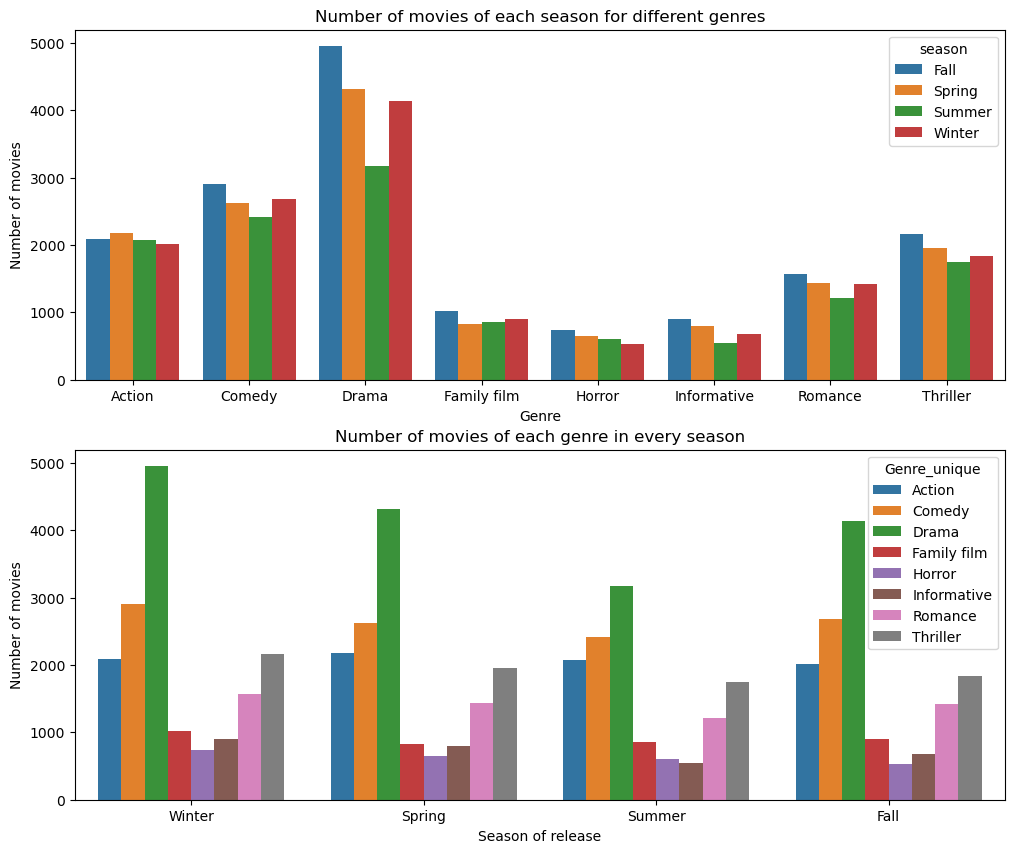

In [59]:
plot_general(df_vis)

The first plot of the figure is useful to compare each genre with itself and on the second one, it is easier to compare each genre to one another
For example on the first plot, we can see that most of the genres have less movies in summer thant in others seasons, except for Action, Horror and Family film movies. On the second one, we can for example see that there are more informative movies than horror movies in spring but it is the opposite in summer.

Both of these figure aren't showing some obvious pattern so we will continue with other kind of visualisation.

#### **2) Looking for pics in months for specific genres**



We first focus on the horror movies. Our goal is to determine if there are pics for certain months, or if the distribution is homogeneous. 

In [46]:
from helpers_part1 import genre_distribution_over_month
from helpers import visu_P2
from helpers import visualizing_data

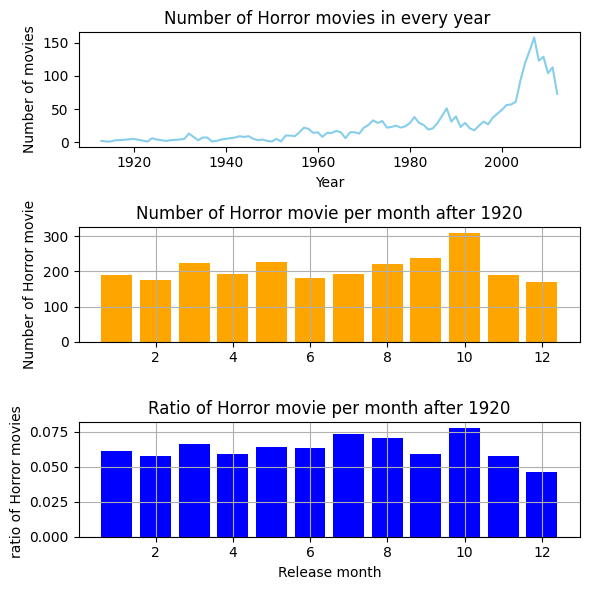

In [47]:
visu_P2(df_vis, 1920, 'Horror')

These plots show the total number of horror movies over the years and the number and ratio of horror movies per months. We decided to keep the movies after 1980 to have enough movies in each year. One can see a clear pic for the month of october.
This tends to show that the horror movies are more released in october which might be linked to Halloween.

Note : The ratio is defined by the number of horror movies in a specific month divided by the number of movies in that month.

**2.2) Evolution of the number of Family movies with months**

Here is the distribution of movies for the Family film genre.

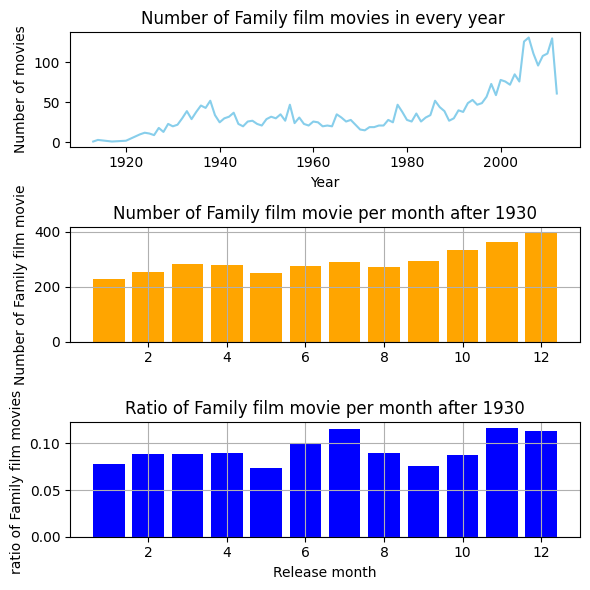

In [49]:
visu_P2(df_vis, 1930, 'Family film')

From the first plot, we decided to consider data from the years 1930, in order to have a consistent analysis with enough data. 

Then in the second and last plots, we can see several pics, one in July and then during Christmas time in November and December. There might be a pattern here which could be linked to the holidays in summer and christmas in november/december

**2.3) Evolution of the number of Romance movies with months**

The following figure shows the distribution of the Romance movies

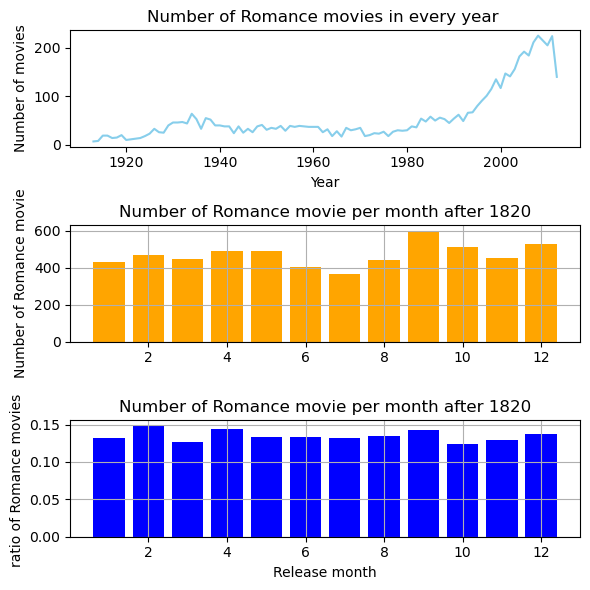

In [35]:
visu_P2(df_vis,1820, 'Romance')

From the first plot, we decided to consider data from the years 1990, in order to have a consistent analysis with enough data. 

The distribution is more homogenous here and we can not clearly see any pics, even if February and April seems to get more Romance movies than usual. It might be because of Valentine's Day!!

Let's explore all of these observations to confirm these first impressions or check if there are simple coincidence. 

# Part 3: Hypothesis testing

#### **1) Relation between the number of horror movies and the release month**
We noticed when plotting the number of horror movies per months a clear pick for the month of October. This assumption seems coherent since Halloween is the 31th of October! 

It could therefore be interesting to perform t-tests in order to reject the null hypothesis: 

H0: "Number of horror movies per year in October == Mean number of horror movies per year not in October."

Let's call the function 'ttest'. This function computes the respective means of the groups in october and not in october for all years, computes the p-value for the hypothesis testing, and also plots the number of horror movies per year for the two groups.

**Note:** From the plots of Part 2, it was found that before the year 1980, the number of horror movies is insufficient to perform a decent analysis, so the function discards the years before 1980.

In [34]:
from helpers_part3 import ttest

In [35]:
# The list of months we want to compare 
months = pd.Series([10])

The average number of Horror movies in ['Oct'] by year (after the year 1980 ) is: 7.45
The average number of Horror movies not in ['Oct'] by year (after the year 1980 ) is: 4.50
The p-value for the t-test is equal to 0.016860 so the null hypothesis is rejected.


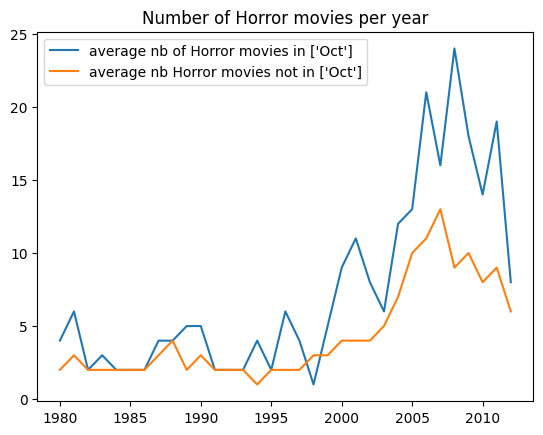

In [37]:
ttest(df_clean_genre,'Horror', months, 1980) #df, genre, month, min year considered (optional)

From the above plot and the result of the t-test, the difference in number of movies is statistically significant. 

#### **2) Relation between the number of Family movies and the release month**

From the plots in Part 2, we noticed 3 pics for the months of July, November, and December. This tendency seems coherent since these periods correspond to holiday breaks.
Let's use again a t-test with the null hypothesis:

H0: "Mean of Family movies per year and per month for July, November, and December == Mean of Family movies per year and per months for all the other months."

**Note:** We consider here the data from all years (see plot of Part 2).

In [52]:
months = pd.Series([7,11,12])

The average number of Family film movies in ['Jul' 'Nov' 'Dec'] by year (after the year 1930 ) is: 4.22
The average number of Family film movies not in ['Jul' 'Nov' 'Dec'] by year (after the year 1930 ) is: 3.30
The p-value for the t-test is equal to 0.027971 so the null hypothesis is rejected.


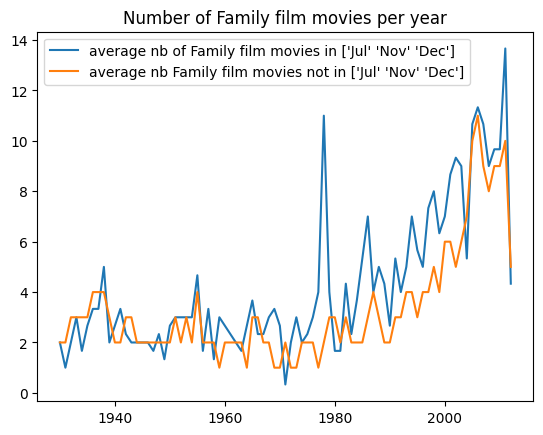

In [54]:
ttest(df_clean_genre,'Family film', months, 1930) #df, genre, month, min year considered (optional)

Here again the null hypothesis is rejected, even if the difference in the plots and in the means is less straight forward. 

#### **3) Relation between the number of Romance and the release month**

From the plots in Part 2, we noticed 1 small pic for the month of February. This tendency seems coherent since this period corresponds to Valentine's day.
Let's use again a t-test with the null hypothesis:

H0: "Mean of Romance movies per year in February == Mean of Romance movies per year not in February."

**Note:** We consider here the data from the years 1990 (see plot of Part 2).

In [42]:
months = pd.Series([2])

The average number of Romance movies in ['Feb'] by year (after the year 1990 ) is: 11.39
The average number of Romance movies not in ['Feb'] by year (after the year 1990 ) is: 11.45
The p-value for the t-test is equal to 1.000000 so the null hypothesis is not rejected.


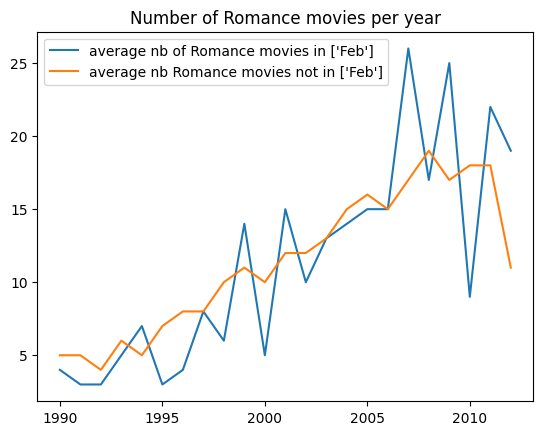

In [43]:
ttest(df_clean_genre,'Romance', months, 1990) #df, genre, month, min year considered (optional)

This time the difference is not statically significant, the null hypothesis is not rejected, so we conclude that there is not more Romance movies in February.